# CO407H - Medical Image Computing

## Tutorial 2 - Filtering, resampling, segmentation

In [1]:
# Use full browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Data

In [5]:
import os

data_dir = "/Volumes/FAIR/DC-Image-Analysis/python tutorials/tutorial2/"
print(os.listdir(data_dir))

['mri-brain-noisy.nii.gz', '._mri-brain-noisy.nii.gz', 'ct-brain-noisy.nii.gz', '._ct-brain-noisy.nii.gz', 'ct-brain-lesion.nii.gz', '._ct-brain-lesion.nii.gz', 'mri-brain-anisotropic.nii.gz', '._mri-brain-anisotropic.nii.gz']


### Set up the image viewer

In [6]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Filtering with SimpleITK

#### Smoothing

Occasionally we will acquire medical scans which include some amount of undesired noise.

One such noisy image might look like this:

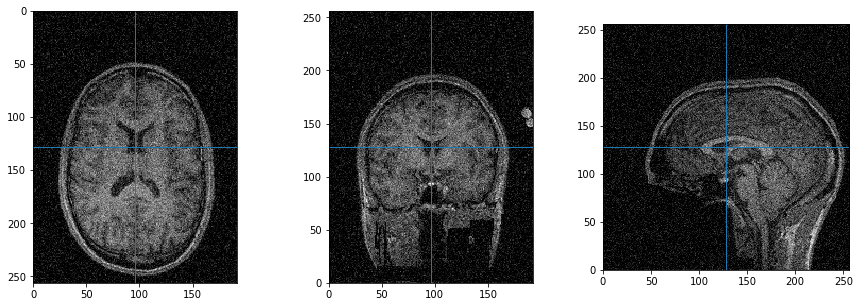

In [7]:
# We convert it to `float32` for compatibility with some functions we'll use later
img = sitk.Cast(sitk.ReadImage(data_dir + 'mri-brain-noisy.nii.gz'), sitk.sitkFloat32)
display_image(img)

A basic denoising technique is to *convolve* the image with a smoothing filter (cf. Introduction slides 108-114).

We can achieve this with SimpleITK using `sitk.DiscreteGaussian(<img>)` (it has a `variance` option, default `=1.0`).

**Task:** Try applying a Gaussian filter to the loaded image. Try out different values for the `variance` parameter:

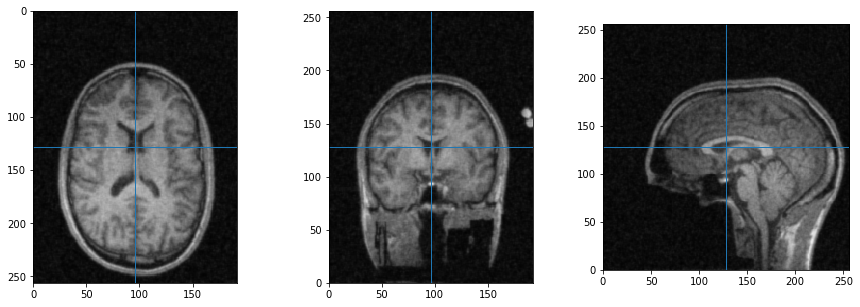

In [8]:
img_gauss = sitk.DiscreteGaussian(img, variance=1)
display_image(img_gauss)

Comparing to the original noisy image, we can see that most of the visible noise is gone, but the image edges also lose their sharpness, in particular with larger values for the variance.

Interestingly, Gaussian smoothing can be interpreted as *isotropic diffusion*, i.e. image intensities are 'diffused' (think heat conduction) homogeneously in all directions for a length of 'time' proportional to the variance of the Gaussian filter. Extending on this idea, another popular approach for denoising is *anisotropic diffusion*, which adjusts the local 'conductivity' based on the image gradients. In other words, it attempts to smooth out flat regions while preserving the edges.

**Task:** Try out the SimpleITK function `sitk.GradientAnisotropicDiffusion(<img>)` (can take a few seconds). Play around with different values for the parameters of this filter:

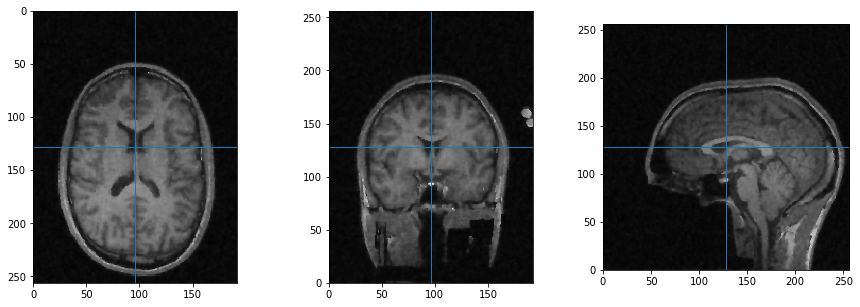

In [9]:
img_diffusion = sitk.GradientAnisotropicDiffusion(img)
display_image(img_diffusion)
#help(sitk.GradientAnisotropicDiffusion)

Let's visualise all three together. Pay attention to the overall noise level and the sharpness of the edges. You might want to adjust the window/level setting for better contrast:

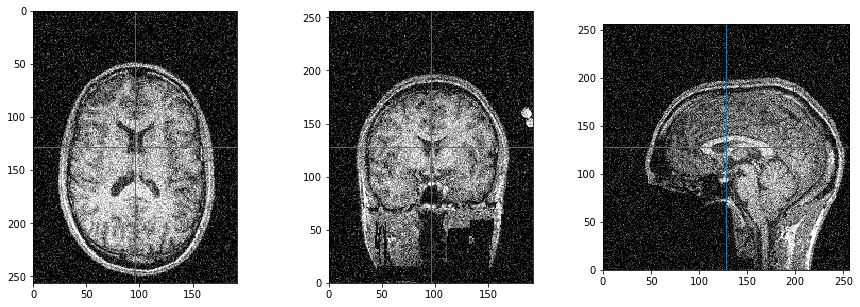

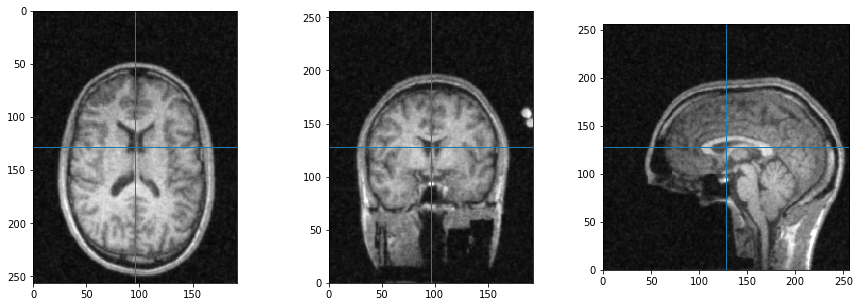

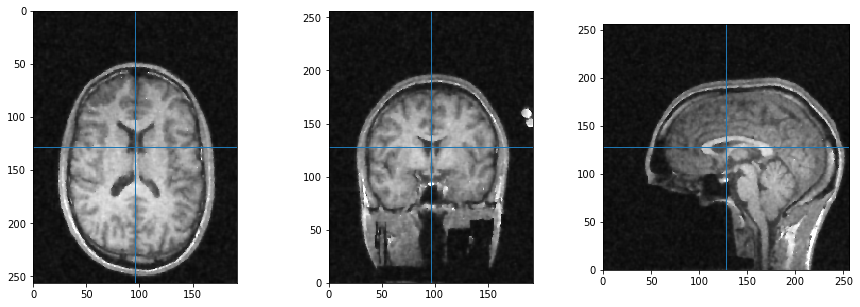

In [10]:
display_image(img, window=400, level=200)
display_image(img_gauss, window=400, level=200)
display_image(img_diffusion, window=400, level=200)

**Task:** Now try the same two smoothing approaches with `'ct-brain-noisy.nii.gz'`:

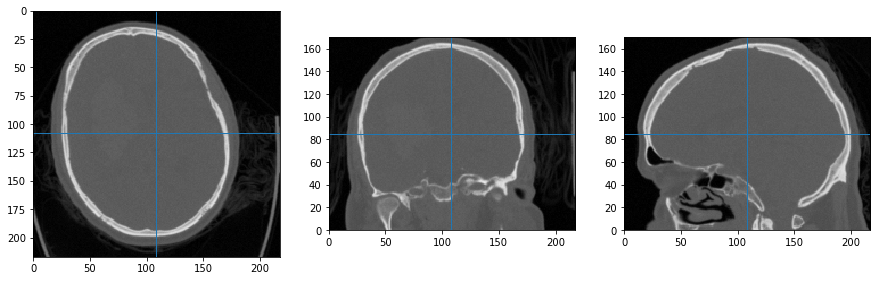

In [9]:
img2 = sitk.Cast(sitk.ReadImage(data_dir + 'ct-brain-noisy.nii.gz'), sitk.sitkFloat32)
display_image(img2)

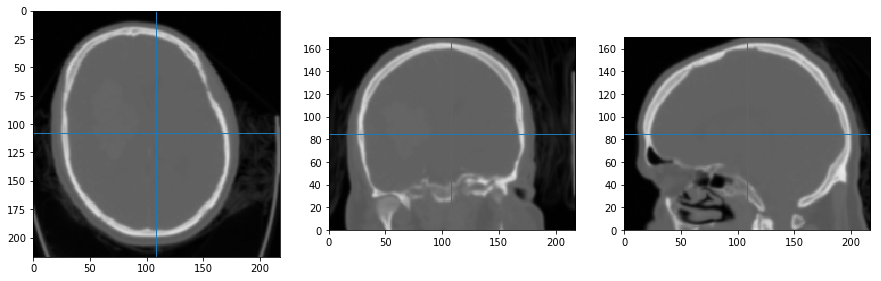

In [10]:
img2_gauss = sitk.DiscreteGaussian(img2)
display_image(img2_gauss)

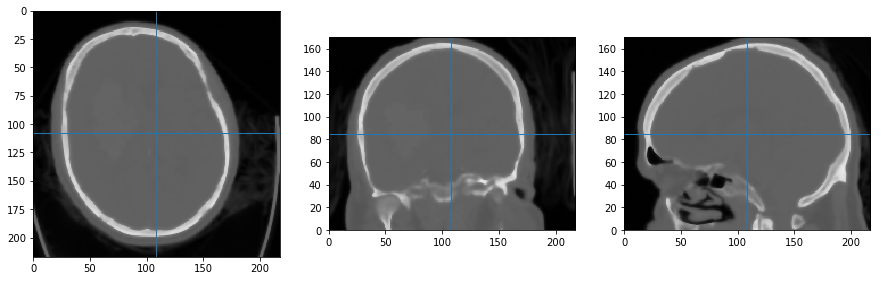

In [11]:
img2_diffusion = sitk.GradientAnisotropicDiffusion(img2)
display_image(img2_diffusion)

**Task:** Again, visualise all three (noisy, blurred and diffused) in the CT intensity range for gray/white matter (`window=120, level=40`) and compare noise levels and edge sharpness.

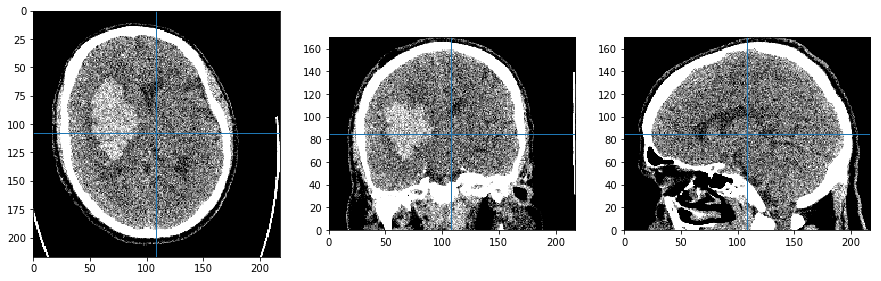

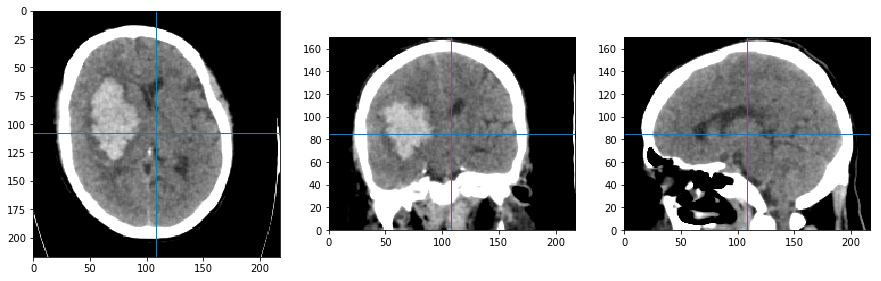

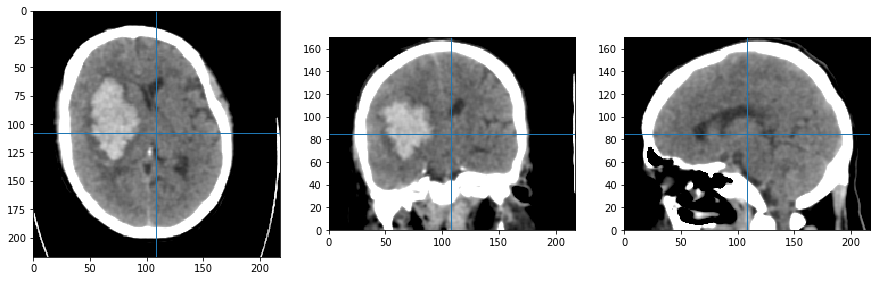

In [12]:
display_image(img2, window=120, level=40)
display_image(img2_gauss, window=120, level=40)
display_image(img2_diffusion, window=120, level=40)

You will notice that each method gives better results for one image but worse for the other. Why do you think that is the case?

*Hint:* Think of the magnitude of the noise compared to the amplitude of the true image variations. If the signal-to-noise ratio if low, the algorithm has no way of knowing what needs to be preserved or smoothed out.

#### Edge detection

Another common application of image filtering is estimating image gradients for edge detection (cf. Introduction lecture slides 115-118).

Let us compute some spatial derivatives with `sitk.Derivative(<img>, direction=<dir>)`, where `<dir>` is 0, 1 or 2 for X, Y or Z, respectively.

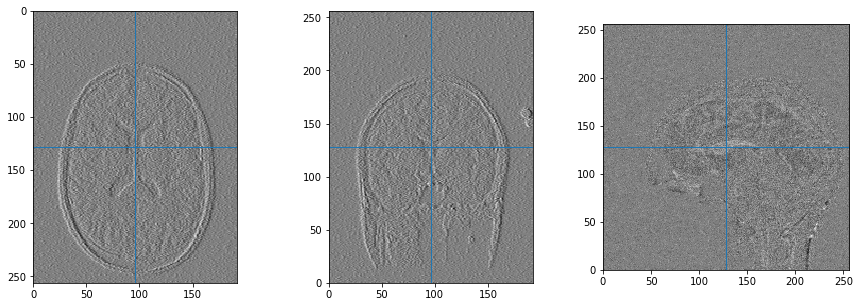

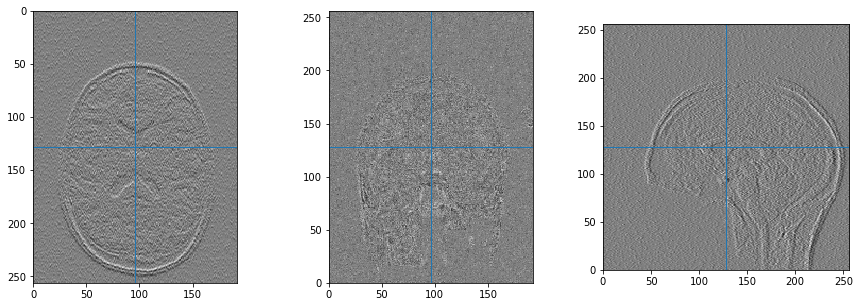

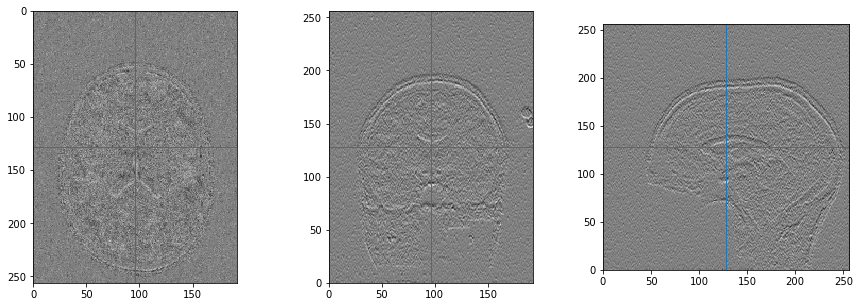

In [15]:
img_dx = sitk.Derivative(img, direction=0)
img_dy = sitk.Derivative(img, direction=1)
img_dz = sitk.Derivative(img, direction=2)
display_image(img_dx, level=0)
display_image(img_dy, level=0)
display_image(img_dz, level=0)

When we compute the magnitude of the gradients of an image, we obtain what is called an *edge map*, which is simply a local measure of the 'strength' of an edge.

This operation is readily available in SimpleITK with `sitk.SobelEdgeDetection(<img>)`:

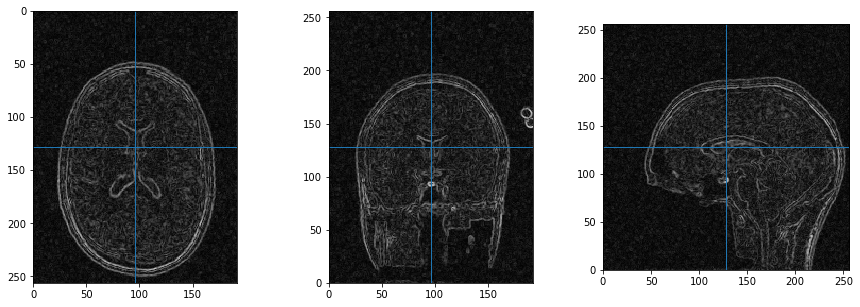

In [16]:
img_sobel = sitk.SobelEdgeDetection(img)
display_image(img_sobel)

Note how the derivatives look quite 'grainy', as we are differentiating the superimposed noise as well.

**Task**: How could you improve the edge detection on a noisy image?

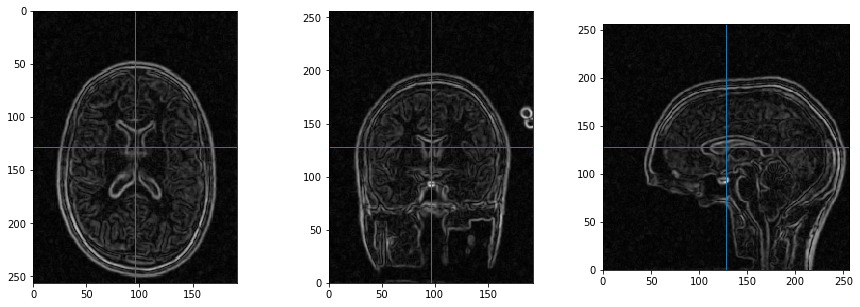

In [17]:
# We run edge detection on the smoothed image
img_sobel2 = sitk.SobelEdgeDetection(img_gauss)
display_image(img_sobel2)

#### Edge sharpening

***Optional Task:*** Have a look at Introduction slides 121-122 and try to implement a `sharpen()` function which applies unsharp masking to an image. It should only use `sitk.DiscreteGaussian`, as above, and take the following arguments:
- `scale`: the standard deviation of the Gaussian filter
- `strength`: the scaling factor for the smoothed image

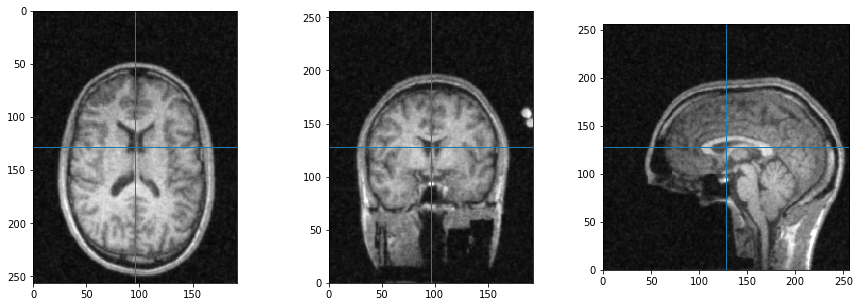

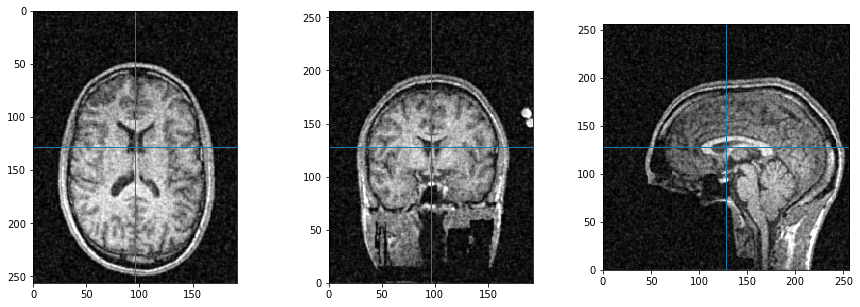

In [18]:
def sharpen(img, scale=1, strength=2):    
    # Apply unsharp masking
    img_smooth = sitk.DiscreteGaussian(img, variance=scale)
    img_sharpened = img + (img - img_smooth) * strength
    return img_sharpened

img_sharp = sharpen(img_gauss, 1, 2)
display_image(img_gauss, window=400, level=200)
display_image(img_sharp, window=400, level=200)

### Resampling

Many image processing or computer vision algorithms adopt a multi-scale approach, for example making a coarse search over the entire image and then refining it at smaller scales. This can be achieved efficiently through the use of so-called *image pyramids* (cf. Introduction slide 89), which are formed by the base image and itself downsampled to lower resolutions, typically by a factor of 2 at each level.

**Task:** Implement a naïve downsampling function, by simply taking one every `<factor>` (integer-valued) pixels in each dimension.

*Hint:* SimpleITK image objects also support Python's indexing notation: `[start:stop:step]`, potentially omitting any of the arguments.

In [19]:
def downsample_naive(img, factor=2):
    return img[::factor, ::factor, ::factor]

Now let us test with the MRI volume from before:

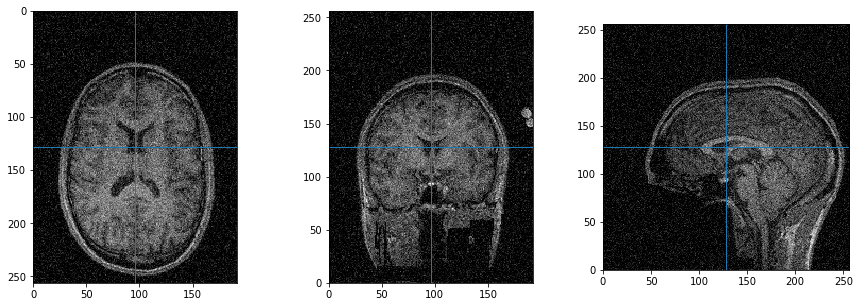

In [20]:
img = sitk.ReadImage(data_dir + "mri-brain-noisy.nii.gz")
display_image(img)

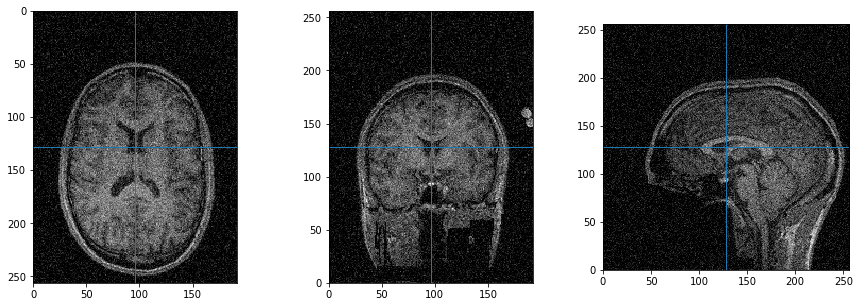

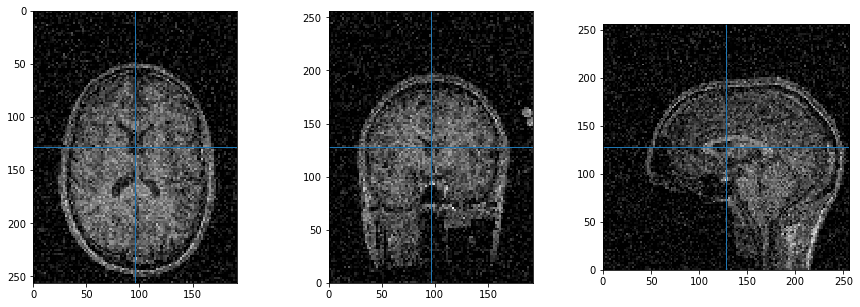

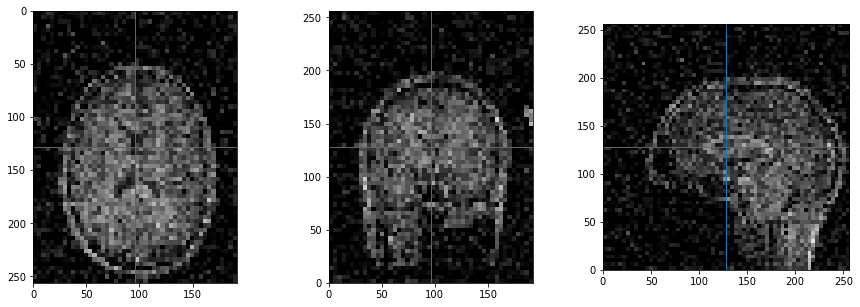

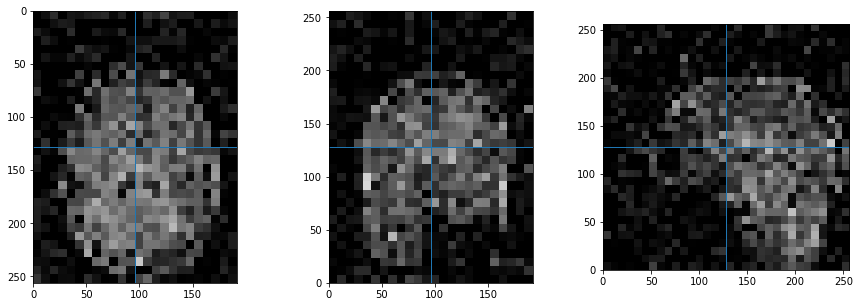

In [21]:
img_down_naive_1 = downsample_naive(img)
img_down_naive_2 = downsample_naive(img_down_naive_1)
img_down_naive_3 = downsample_naive(img_down_naive_2)

display_image(img)
display_image(img_down_naive_1)
display_image(img_down_naive_2)
display_image(img_down_naive_3)

It is known that naïve undersampling can produce *aliasing*, i.e. exacerbate high spatial frequencies (edges and noise) in the downsampled image, making it look jagged and 'blocky'. We usually circumvent this issue by first smoothing the image with a low-pass filter (e.g. Gaussian) before resampling the pixel values.

**Task:** Now try implementing a `downsample` method which first applies a Gaussian smoothing and then downsamples by an integer factor (no interpolation needed).

*Hint:* Recall the `variance` option for `sitk.DiscreteGaussian`. A Gaussian standard deviation of `0.5*factor` works well in practice, but feel free to experiment!

In [22]:
def downsample(img, factor=2):
    smoothed = sitk.DiscreteGaussian(img, variance=(.5 * factor) ** 2)   
    return smoothed[::factor, ::factor, ::factor]

Let's have a look at the results for this approach:

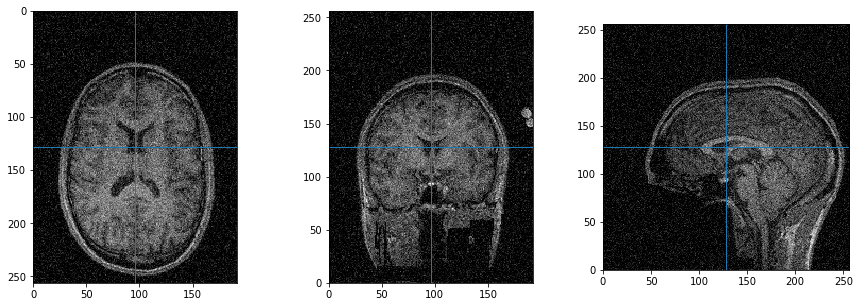

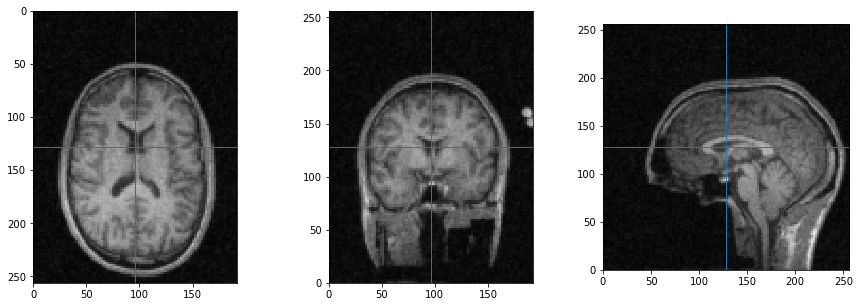

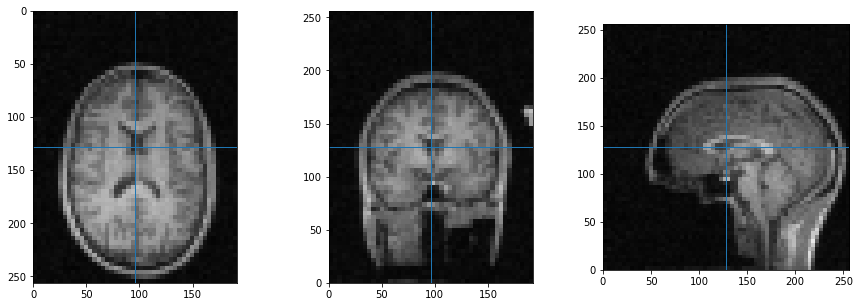

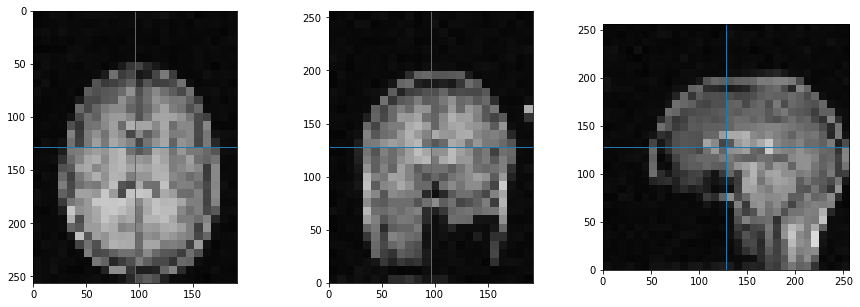

In [23]:
img_down_1 = downsample(img)
img_down_2 = downsample(img_down_1)
img_down_3 = downsample(img_down_2)

display_image(img)
display_image(img_down_1)
display_image(img_down_2)
display_image(img_down_3)

#### Resampling with SimpleITK

SimpleITK offers advanced resampling features that can be useful in many scenarios, e.g. when downsampling by non-integer factors or resampling to a specific resolution (e.g. isotropic).

Have a look at the `resample()` function we have implemented below and try to understand the role of each of the arguments to the `sitk.ResampleImageFilter`.

In [13]:
def resample(img, new_size=None, new_spacing=None):
    old_size = img.GetSize()
    old_spacing = img.GetSpacing()
    
    if new_size is None and new_spacing is None:
        return img
    
    if new_size is None:
        # Compute new image dimensions based on the desired rescaling of the voxel spacing
        new_size = [int(np.ceil(old_size[d] * old_spacing[d] / new_spacing[d])) for d in range(3)]

    if new_spacing is None:
        # Compute new voxel spacing based on the desired rescaling of the image dimensions
        new_spacing = [old_spacing[d] * old_size[d] / new_size[d] for d in range(3)]

    # Smooth the input image with anisotropic Gaussian filter
    img_smoothed = img
    for d in range(3):
        # Note how the blurring strength can be different in each direction,
        # if the scaling factors are different.
        factor = new_spacing[d] / old_spacing[d]
        sigma = 0.2 * factor
        img_smoothed = sitk.RecursiveGaussian(img_smoothed, sigma=sigma, direction=d)

    # Finally, apply the resampling operation
    img_resampled = sitk.ResampleImageFilter().Execute(
        img_smoothed,        # Input image
        new_size,            # Output image dimensions
        sitk.Transform(),    # Coordinate transformation. sitk.Transform() is a dummy identity transform,
                             # as we want the brain to be in exactly the same place. When we do image registration,
                             # for example, this can be a linear or nonlinear transformation.
        sitk.sitkLinear,     # Interpolation method (cf. also sitk.sitkNearestNeighbor and many others)
        img.GetOrigin(),     # Output image origin (same)
        new_spacing,         # Output voxel spacing
        img.GetDirection(),  # Output image orientation (same)
        0,                   # Fill value for points outside the input domain
        img.GetPixelID())    # Voxel data type (same)

    return img_resampled

Let's resample the MR image to an element spacing of 2x4x8mm.

Spacing: (1.0, 1.000000238418579, 0.9999995827674866)


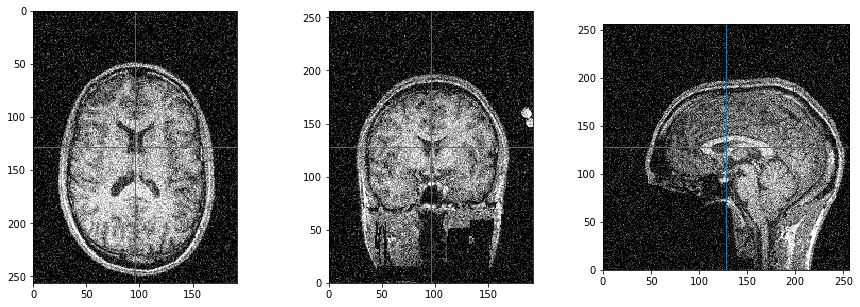

Spacing: (2.0, 4.0, 8.0)


In [14]:
img_resampled = resample(img, new_spacing=[2, 4, 8])

print("Spacing: {}".format(img.GetSpacing()))
display_image(img, window=400, level=200)

print("Spacing: {}".format(img_resampled.GetSpacing()))
display_image(img_resampled, window=400, level=200)

On slide 90 in the Introduction slides we discussed the problem that medical imaging data is often anisotropic. For many image analysis algorithms, however, it is easier to work with isotropic input data.

Here is the example image from the lecture slides:

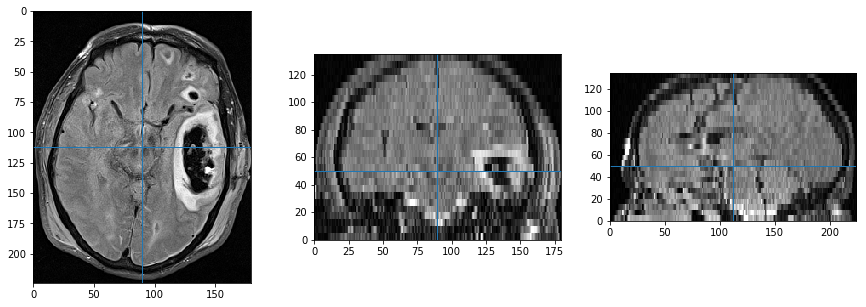

In [26]:
img3 = sitk.ReadImage(data_dir + 'mri-brain-anisotropic.nii.gz')
display_image(img3, z=10, window=800, level=400)

** Task: ** Try resampling the above image to an isotropic 1mm resolution, and display the result showing approximately the same xy-plane by setting an appropriate value for the `z` parameter in the `display_image` function.

Spacing: (0.699999988079071, 0.699999988079071, 5.0)


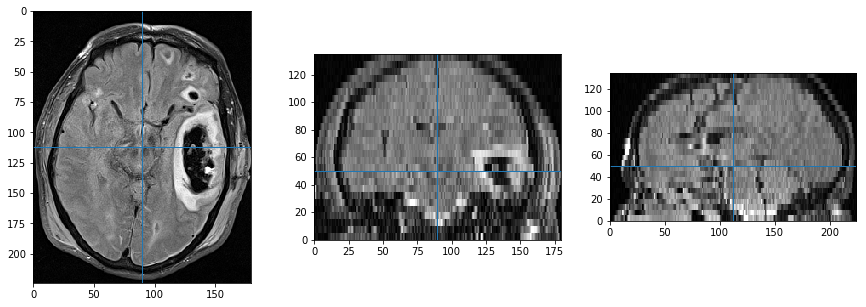

Spacing: (1.0, 1.0, 1.0)


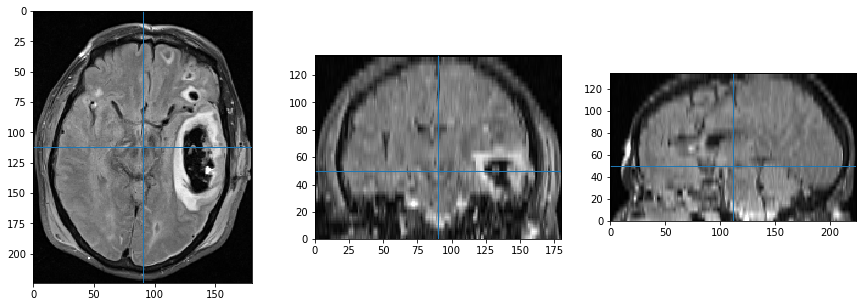

In [27]:
img3_resampled = resample(img3, new_spacing=[1, 1, 1])

print("Spacing: {}".format(img3.GetSpacing()))
display_image(img3, z=10, window=800, level=400)

print("Spacing: {}".format(img3_resampled.GetSpacing()))
display_image(img3_resampled, z=50, window=800, level=400)

### Segmentation

First let us define some helper functions to overlay an image with a segmentation, for good visualisation. `display_overlay()` takes as input the base image, a segmentation image (binary) and all the usual arguments for `display_image()`:

In [28]:
def label_overlay(img, seg):
    minmax = sitk.MinimumMaximumImageFilter()
    minmax.Execute(img)
    low, high = minmax.GetMinimum(), minmax.GetMaximum()
    img_norm = (img - low) / (high - low)
    img_uint8 = sitk.Cast(256 * img_norm, sitk.sitkUInt8)
    return sitk.LabelOverlay(img_uint8, seg)

def display_overlay(img, seg, *args, **kwargs):
    display_image(label_overlay(img, seg), *args, **kwargs)

#### Thresholding

As we have seen in the Segmentation lecture (slides 44-51), the simplest form of segmentation is just based on a single cutoff in the intensities, with a manually specified threshold. Alternatively, we can specify an upper and a lower thresholds.

**Task:** Try to find a good UL thresholding to segment the lesion in the noisy CT scan. You might find some hints for good thresholds in the lecture slides.

*Hint 1:* SimpleITK images support comparison (`<`, `>`, `<=`, `>=`, `==`, `!=`) and logical ('and' `&`, 'or' `|`, 'xor' `^`, 'not' `~`) operators to produce binary images.

*Hint 2:* Image noise causes major problems for thresholding approaches. Try removing noise before thresholding the image and compare the results.

In [29]:
img = sitk.ReadImage(data_dir + 'ct-brain-noisy.nii.gz')
display_image(img, x=70, y=100, z=90, window=120, level=40)

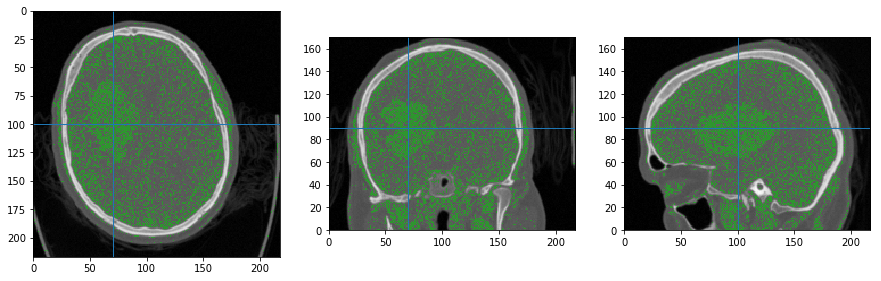

In [30]:
seg = (img > 50) & (img < 100)
display_overlay(img, seg, x=70, y=100, z=90)

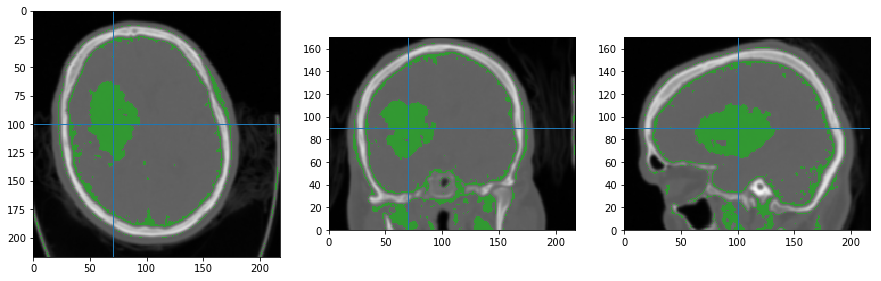

In [31]:
img_gauss = sitk.DiscreteGaussian(img)
seg = (img_gauss > 50) & (img_gauss < 100)
display_overlay(img_gauss, seg, x=70, y=100, z=90)

Here we can observe one of the main shortcomings of purely intensity-based segmentation methods: we have no control over the location or spatial contiguity of the segmented regions. So even if we manage to segment most of the lesion, there are lot of areas included with the same intensity range outside the structure of interest.

#### Region growing

Region growing offers an alternative to simple thresholding that addresses the issue of spatial contiguity: it only labels the voxels which are *reachable* from a set of manually-specified *seed points*. In its simplest form, it is equivalent to thresholding, but limited to regions connected to the seeds.

**Task:** Implement region growing with UL thresholding.

*Hints:*
- The basic idea is given as pseudo-code on slide 68.
- To initialise your zero-filled segmentation image, use `sitk.Image(<img>.GetSize(), sitk.sitkUInt8)`. Don't forget to also call `<seg>.CopyInformation(<img>)` to copy the meta-data (spacing, origin, orientation) from the input image.
- You can use Python's `collections.deque` (double-ended queue). Use `.append(<elem>)` or `.extend(<list>)` to enqueue elements and `.popleft()` to dequeue an element (`.pop()` would work as a stack instead).
- Your algorithm should remember which voxels have already been visited. This can be achieved with a Python set (`set()`), with which you can do `.add(<elem>)` and `if <elem> in <set>:`.
- Use tuples to represent the voxel locations (e.g. `point=(x,y,z)`), then you can index directly into the SimpleITK image with them (e.g. `image[point]`).
- `neighbours(<point>, <img_size>)` returns the list of immediate neighbours of `<point>`, clipped at the image borders.

In [32]:
def neighbours(x, size):
    nbs = []
    for d in range(len(x)):
        if x[d] > 0:
            nb = list(x)
            nb[d] -= 1
            nbs.append(tuple(nb))
        if x[d] < size[d] - 1:
            nb = list(x)
            nb[d] += 1
            nbs.append(tuple(nb))
    return nbs

In [33]:
from collections import deque

def region_growing(img, seeds, low, high):
    size = img.GetSize()
    seg = sitk.Image(size, sitk.sitkUInt8)
    queue = deque()
    queue.extend(seeds)
    visited = set()
    while len(queue) > 0:
        x = queue.popleft()
        if x in visited:
            continue
        visited.add(x)
        if low <= img[x] < high:
            seg[x] = 1
            queue.extend(neighbours(x, size))
    seg.CopyInformation(img)
    return seg

In [34]:
display_image(img_gauss, x=70, y=100, z=90, window=120, level=40)

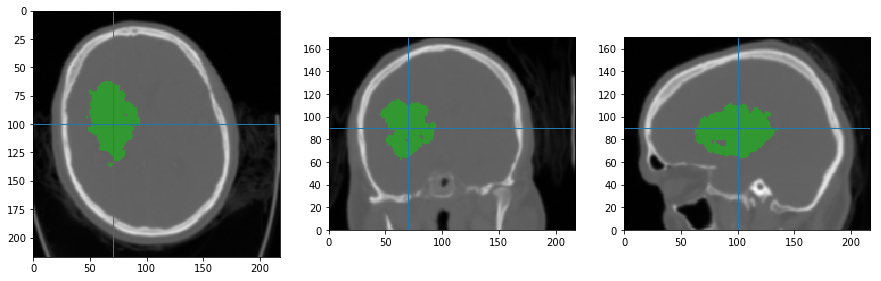

In [35]:
seed = (70, 100, 90)
low, high = 50, 100
seg2 = region_growing(img_gauss, [seed], low, high)
display_overlay(img_gauss, seg2, *seed)

Let's visually compare the results to a manual reference segmentation.

Thresholding


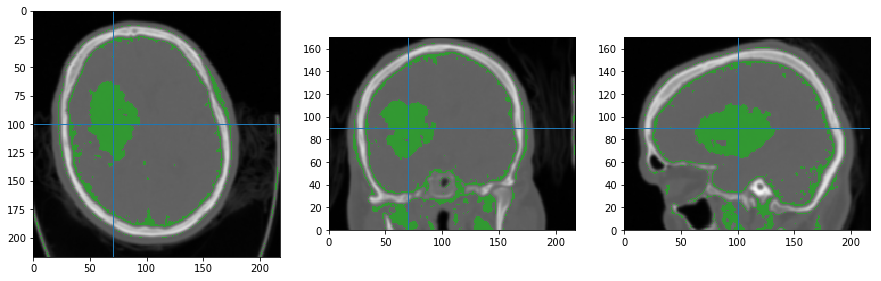

Region growing


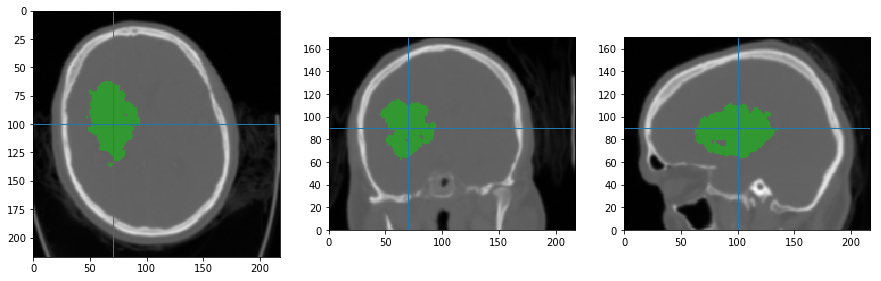

Reference segmentation


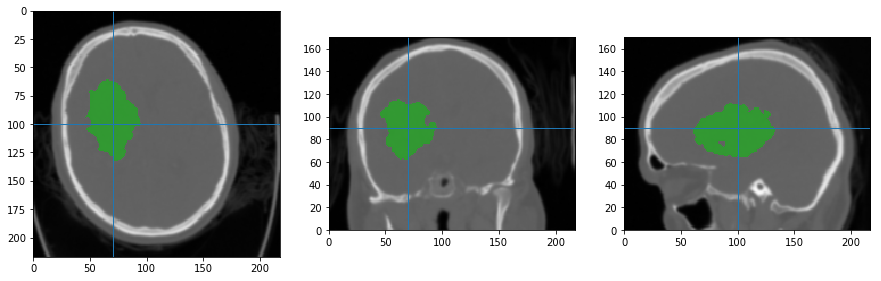

In [36]:
ref = sitk.ReadImage(data_dir + 'ct-brain-lesion.nii.gz')

print("Thresholding")
display_image(label_overlay(img_gauss, seg), *seed)
print("Region growing")
display_image(label_overlay(img_gauss, seg2), *seed)
print("Reference segmentation")
display_image(label_overlay(img_gauss, ref), *seed)

#### Evaluation using Dice Similarity Coefficient

Let's now quantitatively evaluate the segmentations using different performance measures as discussed in the lecture from slide 30 and following. SimpleITK has many important measures already implemented.

First, we extract the surfaces from the segmentations.

Thresholding - Surface


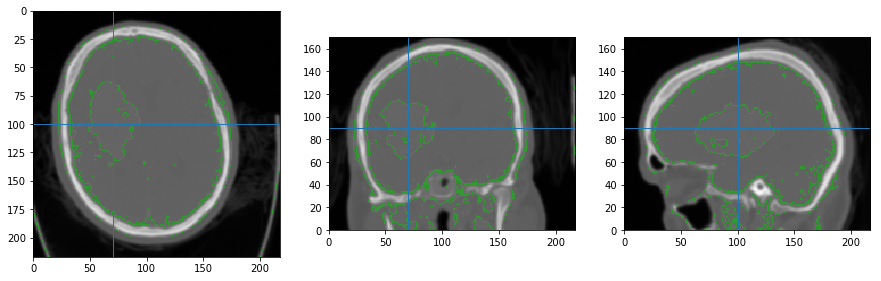

Region growing - Surface


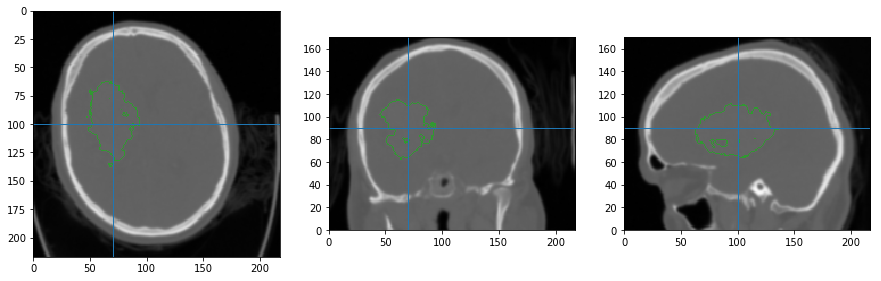

Reference segmentation - Surface


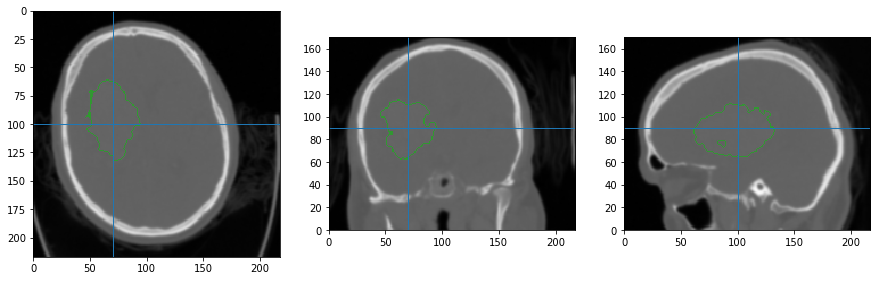

In [37]:
seg_contour = sitk.LabelContour(seg)
seg2_contour = sitk.LabelContour(seg2)
ref_contour = sitk.LabelContour(ref)

print("Thresholding - Surface")
display_image(label_overlay(img_gauss, seg_contour), *seed)
print("Region growing - Surface")
display_image(label_overlay(img_gauss, seg2_contour), *seed)
print("Reference segmentation - Surface")
display_image(label_overlay(img_gauss, ref_contour), *seed)

Then we can use SimpleITK to compute overlap measures such as Jaccard Index (JI) and Dice Similarity Coefficient (DSC). We can also directly compute the Hausdorff Distance (HD) from the segmentation contours using SimpleITK's `HausdorffDistanceImageFilter`.

In [38]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

overlap_measures_filter.Execute(ref, seg)
hausdorff_distance_filter.Execute(ref_contour, seg_contour)
print('\nThresholding')
print('JI\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC\t' + str(overlap_measures_filter.GetDiceCoefficient()))
print('HD\t' + str(hausdorff_distance_filter.GetHausdorffDistance()))

overlap_measures_filter.Execute(ref, seg2)
hausdorff_distance_filter.Execute(ref_contour, seg2_contour)
print('\nRegion growing')
print('JI\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC\t' + str(overlap_measures_filter.GetDiceCoefficient()))
print('HD\t' + str(hausdorff_distance_filter.GetHausdorffDistance()))


Thresholding
JI	0.17586102539437207
DSC	0.29911872508129106
HD	179.0139659356219

Region growing
JI	0.9202243906513176
DSC	0.9584550588269407
HD	11.224972160321824


Computing the Average Surface Distance (ASD) is a bit more involved, but we can make use of the `SignedMaurerDistanceMap` in SimpleITK. We then follow the approach described in slide 35 and following.

Thresholding - Distance Map


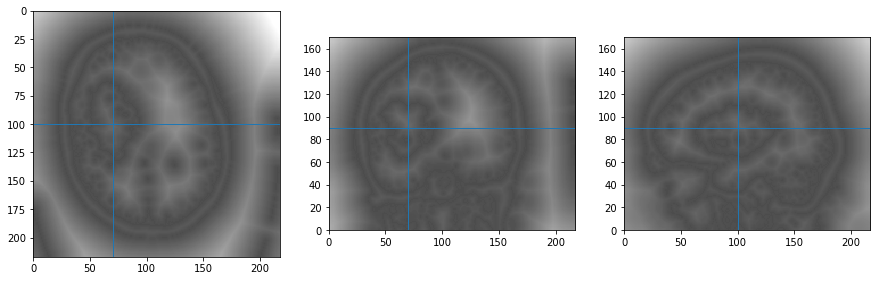

Region growing - Distance Map


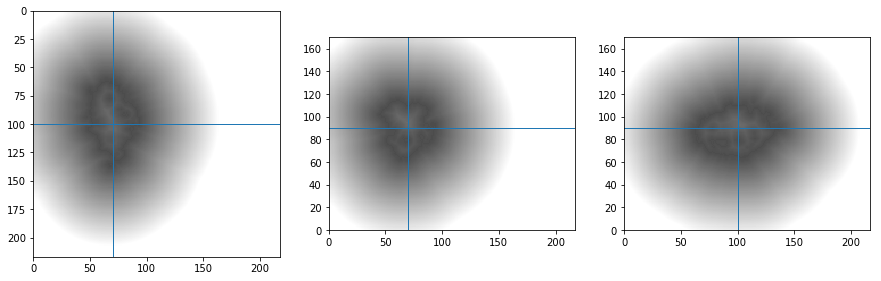

Reference - Distance Map


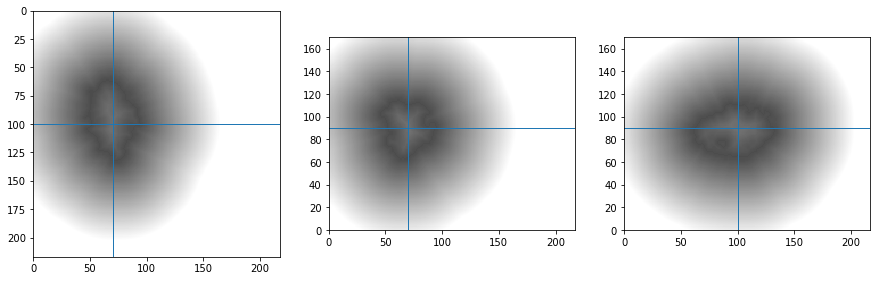

In [39]:
seg_distance_map = sitk.SignedMaurerDistanceMap(seg_contour, squaredDistance=False, useImageSpacing=True)
seg2_distance_map = sitk.SignedMaurerDistanceMap(seg2_contour, squaredDistance=False, useImageSpacing=True)
ref_distance_map = sitk.SignedMaurerDistanceMap(ref_contour, squaredDistance=False, useImageSpacing=True)

print('Thresholding - Distance Map')
display_image(seg_distance_map, *seed, window=100, level=20)

print('Region growing - Distance Map')
display_image(seg2_distance_map, *seed, window=100, level=20)

print('Reference - Distance Map')
display_image(ref_distance_map, *seed, window=100, level=20)

We convert everything to numpy arrays.

In [40]:
# segmentations
seg_np = sitk.GetArrayFromImage(seg).astype(bool)
seg2_np = sitk.GetArrayFromImage(seg2).astype(bool)
ref_np = sitk.GetArrayFromImage(ref).astype(bool)

# surfaces
seg_contour_np = sitk.GetArrayFromImage(seg_contour).astype(bool)
seg2_contour_np = sitk.GetArrayFromImage(seg2_contour).astype(bool)
ref_contour_np = sitk.GetArrayFromImage(ref_contour).astype(bool)

# distance maps
seg_distance_map_np = sitk.GetArrayFromImage(seg_distance_map)
seg2_distance_map_np = sitk.GetArrayFromImage(seg2_distance_map)
ref_distance_map_np = sitk.GetArrayFromImage(ref_distance_map)

Now we can compute ASD by reading out the distances for surface pixels overlaid on the respective distance map.

In [41]:
distance_dir1 = np.mean(ref_distance_map_np[seg_contour_np])
distance_dir2 = np.mean(seg_distance_map_np[ref_contour_np])
print('\nThresholding')
print('ASD\t' + str(np.max([distance_dir1, distance_dir2])))

distance_dir1 = np.mean(ref_distance_map_np[seg2_contour_np])
distance_dir2 = np.mean(seg2_distance_map_np[ref_contour_np])
print('\nRegion growing')
print('ASD\t' + str(np.max([distance_dir1, distance_dir2])))


Thresholding
ASD	56.3144

Region growing
ASD	0.840394


**Task:** Similarily, we can compute the Hausdorff Distance ourselves. Try it and compare the values to the ones obtained with SimpleITK.

In [42]:
hausdorff_dir1 = np.max(ref_distance_map_np[seg_contour_np])
hausdorff_dir2 = np.max(seg_distance_map_np[ref_contour_np])
print('\nThresholding')
print('HD (ours)\t' + str(np.max([hausdorff_dir1, hausdorff_dir2])))

hausdorff_distance_filter.Execute(ref_contour, seg_contour)
print('HD (SimpleITK)\t' + str(hausdorff_distance_filter.GetHausdorffDistance()))

hausdorff_dir1 = np.max(ref_distance_map_np[seg2_contour_np])
hausdorff_dir2 = np.max(seg2_distance_map_np[ref_contour_np])
print('\nRegion growing')
print('HD (ours)\t' + str(np.max([hausdorff_dir1, hausdorff_dir2])))

hausdorff_distance_filter.Execute(ref_contour, seg2_contour)
print('HD (SimpleITK)\t' + str(hausdorff_distance_filter.GetHausdorffDistance()))


Thresholding
HD (ours)	179.014
HD (SimpleITK)	179.0139659356219

Region growing
HD (ours)	11.225
HD (SimpleITK)	11.224972160321824


It's also quite easy to compute the Jaccard Index (JI) and Dice Similarity Coefficient (DSC) directly using numpy. To this end, let's first determine the true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

In [43]:
tp = np.sum( seg_np &  ref_np)
fp = np.sum( seg_np & ~ref_np)
tn = np.sum(~seg_np & ~ref_np)
fn = np.sum(~seg_np &  ref_np)

** Task: ** Now compute JI and DSC for both results, thresholding and region growing, and compare the values to the ones obtained with SimpleITK.

In [44]:
seg2_np = sitk.GetArrayFromImage(seg2).astype(bool)
tp2 = np.sum( seg2_np &  ref_np)
fp2 = np.sum( seg2_np & ~ref_np)
tn2 = np.sum(~seg2_np & ~ref_np)
fn2 = np.sum(~seg2_np &  ref_np)

In [45]:
jaccard = tp / (tp + fp + fn)
dice = 2 * tp / (2 * tp + fp + fn)

jaccard2 = tp2 / (tp2 + fp2 + fn2)
dice2 = 2 * tp2 / (2 * tp2 + fp2 + fn2)

In [46]:
overlap_measures_filter.Execute(ref, seg)
print('\nThresholding')
print('JI (ours)\t' + str(jaccard))
print('JI (SimpleITK)\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC (ours)\t' + str(dice))
print('DSC (SimpleITK)\t' + str(overlap_measures_filter.GetDiceCoefficient()))

overlap_measures_filter.Execute(ref, seg2)
print('\nRegion growing')
print('JI (ours)\t' + str(jaccard2))
print('JI (SimpleITK)\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC (ours)\t' + str(dice2))
print('DSC (SimpleITK)\t' + str(overlap_measures_filter.GetDiceCoefficient()))


Thresholding
JI (ours)	0.175861025394
JI (SimpleITK)	0.17586102539437207
DSC (ours)	0.299118725081
DSC (SimpleITK)	0.29911872508129106

Region growing
JI (ours)	0.920224390651
JI (SimpleITK)	0.9202243906513176
DSC (ours)	0.958455058827
DSC (SimpleITK)	0.9584550588269407
